In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn import tree
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

from datetime import datetime
start_time = datetime.now()

In [2]:
df_trn = pd.read_csv('option_train.csv')

df_trn.head()

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420.0,0.341270,0.03013,Under
1,0.125000,427.015526,465.0,0.166667,0.03126,Over
2,20.691244,427.762336,415.0,0.265873,0.03116,Under
3,1.035002,451.711658,460.0,0.063492,0.02972,Over
4,39.553020,446.718974,410.0,0.166667,0.02962,Under


In [3]:
df_tst = pd.read_csv('option_test_wolabel.csv')
df_tst.head()

,S,K,tau,r
0,431.618600,460,0.293651,0.03147
1,432.633296,420,0.182540,0.03147
2,432.633296,430,0.182540,0.03147
3,431.618600,415,0.293651,0.03147
4,434.772855,420,0.043651,0.03147


In [4]:
df_trn.describe(include='all')

,Value,S,K,tau,r,BS
count,1678.000000,1679.000000,1678.000000,1679.000000,1680.000000,1680
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,Under
freq,NaN,NaN,NaN,NaN,NaN,946
mean,15.068709,464.402535,438.241955,0.437519,0.030235,NaN
std,14.040023,973.652179,23.408989,7.057555,0.000557,NaN
min,0.125000,0.000000,375.000000,0.003968,0.029510,NaN
25%,2.255001,433.863864,420.000000,0.119048,0.029820,NaN
50%,11.190967,442.634081,440.000000,0.202381,0.030130,NaN
75%,25.747434,447.320414,455.000000,0.285714,0.030540,NaN


In [5]:
df_trn.isnull().sum()

Value    2
S        1
K        2
tau      1
r        0
BS       0
dtype: int64

In [6]:
print(df_trn[df_trn['S']==0].index.values)

[879]


In [7]:
print(df_trn[df_trn['S']==40333].index.values)

[47]


In [8]:
df_trn.drop(index=[47,879], inplace= True)

In [9]:
df_trn[df_trn['tau'] > df_trn['tau'].mean() + 3 * df_trn['tau'].std()]

,Value,S,K,tau,r,BS
12,2.315001,448.688109,470.0,250.0,0.03013,Over
33,2.565000,445.042240,455.0,146.0,0.03003,Over


In [10]:
df_trn.drop(index=[12,33], inplace= True)

In [11]:
df_trn[df_trn['Value'] > df_trn['Value'].mean() + 3 * df_trn['Value'].std()]

,Value,S,K,tau,r,BS
205,59.825169,430.638719,375.0,0.289683,0.03178,Under
1275,60.149367,431.020394,375.0,0.285714,0.03168,Under


In [12]:
df_trn.drop(index=[205,1275], inplace= True)

In [13]:
df_trn.dropna(inplace = True)

In [14]:
df_trn.describe(include='all')

,Value,S,K,tau,r,BS
count,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671
unique,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,Under
freq,NaN,NaN,NaN,NaN,NaN,942
mean,15.042632,440.912904,438.291442,0.201920,0.030233,NaN
std,13.972687,7.525507,23.332369,0.099829,0.000555,NaN
min,0.125000,425.472331,375.000000,0.003968,0.029510,NaN
25%,2.205005,433.886762,420.000000,0.119048,0.029820,NaN
50%,11.220588,442.634081,440.000000,0.202381,0.030130,NaN
75%,25.745904,447.320414,455.000000,0.285714,0.030540,NaN


In [15]:
df_trn['BS'] = np.where(df_trn['BS'] == 'Over', 1, 0)

In [16]:
df_trn.head()

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420.0,0.341270,0.03013,0
1,0.125000,427.015526,465.0,0.166667,0.03126,1
2,20.691244,427.762336,415.0,0.265873,0.03116,0
3,1.035002,451.711658,460.0,0.063492,0.02972,1
4,39.553020,446.718974,410.0,0.166667,0.02962,0


/var/folders/6y/g7ff8wvs7vs0kjfty1qy4ll40000gn/T/ipykernel_47378/3627355042.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_trn.corr(), dtype=np.bool))


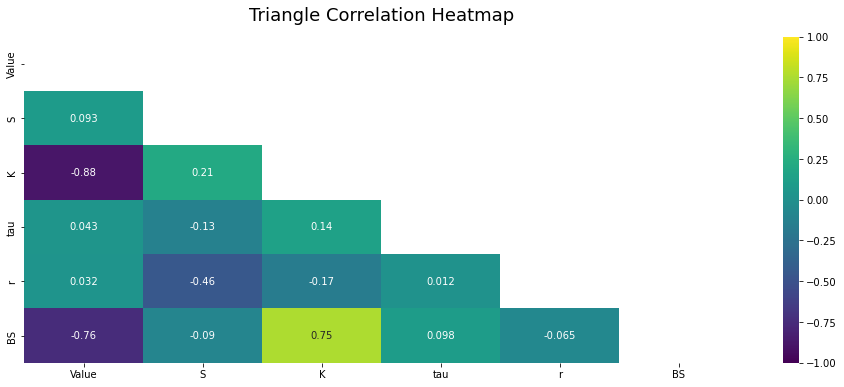

In [17]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_trn.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_trn.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap = "viridis")
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [18]:
modeling_output = pd.DataFrame(columns=['Model','Trn','Tst'],index=range(1000))
counter = 0
model_counter = 0

## Regression

In [19]:
# Linear Regression
LR1 = smf.ols('Value ~ S + K + tau +r', data= df_trn).fit()

In [20]:
LR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     4288.
Date:                Tue, 25 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:26:33   Log-Likelihood:                -4751.7
No. Observations:                1671   AIC:                             9513.
Df Residuals:                    1666   BIC:                             9540.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.8088     11.216     -1.855      0.064     -42.807       1.190
S              0.6208      0.016     39.795      0.000       0.590       0.651
K             -0.5890      0.005   -129.581      0.000      -0.598      -0.580
tau           31.4802      1.045     30.117      0.000      29.430      33.530
r            460.1351    207.133      2.221      0.026      53.866     866.404
==============================================================================
Omnibus:                      154.524   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              199.275
Skew:                           0.846   Prob(JB):                     5.35e-44
Kurtosis:                       3.049   Cond. No.                     1.27e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#  Decision Tree Regression
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y = df_trn['Value'].values

scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3)

    clf_tree = DecisionTreeRegressor()
    path = clf_tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas

    kfolds = KFold(n_splits = 10, shuffle = True)

    r2 = []
    for ccp_alpha in ccp_alphas:
      score_for_alpha = []
      for train_index, test_index in kfolds.split(X_train, y_train):
        clf = DecisionTreeRegressor(ccp_alpha=ccp_alpha, min_samples_leaf = 30)
        clf.fit(X_train[train_index], y_train[train_index])
        y_pred = clf.predict(X_train[test_index])
        score = r2_score(y_pred, y_train[test_index])
        score_for_alpha.append(score)
      r2.append(sum(score_for_alpha)/len(score_for_alpha))

    alpha_cv = ccp_alphas[np.argmax(r2)]
    clf_tree_final = DecisionTreeRegressor(ccp_alpha=alpha_cv, min_samples_leaf = 30)
    clf_tree_final.fit(X_train, y_train)

    y_pred_train = clf_tree_final.predict(X_train)
    score_train = r2_score(y_train, y_pred_train)

    y_pred_test = clf_tree_final.predict(X_test)
    score_test = r2_score(y_test, y_pred_test)
    modeling_output.iloc[counter] = ['Decision Tree reg', score_train, score_test]
    counter = counter + 1
    model_counter = model_counter + 1

    scores.append(score_test)

score_test = np.mean(np.array(scores))
print(score_test)

0.9505898637334307


In [22]:
# random forest hyperparameter tuning
RF = RandomForestRegressor(random_state = 0)

RF_param = {'n_estimators': [20, 50, 100, 150, 200],
            'max_depth': np.arange(1,10),
            'max_features': np.arange(2,4),
            'min_samples_leaf': np.arange(1,10),
            'min_samples_split': np.arange(2,10),
            'criterion': ['absolute_error', 'friedman_mse'] }

RF_cv = RandomizedSearchCV(RF, param_distributions=RF_param, cv=10, n_iter=20, random_state=0)
RF_cv.fit(X, y)
RF_cv.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 3,
 'max_depth': 7,
 'criterion': 'absolute_error'}

In [23]:
RF_best = RandomForestRegressor(n_estimators = RF_cv.best_params_['n_estimators'],
                                max_features = RF_cv.best_params_['max_features'],
                                max_depth = RF_cv.best_params_['max_depth'],
                                criterion = RF_cv.best_params_['criterion'],
                                min_samples_leaf = RF_cv.best_params_['min_samples_leaf'],
                                min_samples_split = RF_cv.best_params_['min_samples_split'],
                                random_state = 0)

In [24]:
# Random Forest Regression
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y = df_trn['Value'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3)

    clf_rf = RF_best
    clf_rf.fit(X_train, y_train)

    y_pred_train_rf = clf_rf.predict(X_train)
    score_train_rf = r2_score(y_train, y_pred_train_rf)

    y_pred_rf = clf_rf.predict(X_test)
    score_test_rf = r2_score(y_test, y_pred_rf)

    modeling_output.iloc[counter] = ['Random Forest reg', score_train_rf, score_test_rf]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_rf)

score_test_rf = np.mean(np.array(score))
print(score_test_rf)

0.9857597154276105


In [25]:
# Random Forest Regression
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y = df_trn['Value'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3)

    clf_rf =  RandomForestRegressor(n_estimators = 100)
    clf_rf.fit(X_train, y_train)

    y_pred_train_rf = clf_rf.predict(X_train)
    score_train_rf = r2_score(y_train, y_pred_train_rf)

    y_pred_rf = clf_rf.predict(X_test)
    score_test_rf = r2_score(y_test, y_pred_rf)

    modeling_output.iloc[counter] = ['Random Forest reg', score_train_rf, score_test_rf]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_rf)

score_test_rf = np.mean(np.array(score))
print(score_test_rf)

0.9949720927398591


## Classification

In [26]:
LG = smf.logit('BS ~ S + K + tau +r', data= df_trn).fit()
LG.summary()

Optimization terminated successfully.
         Current function value: 0.208188
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     BS   No. Observations:                 1671
Model:                          Logit   Df Residuals:                     1666
Method:                           MLE   Df Model:                            4
Date:                Tue, 25 Jun 2024   Pseudo R-squ.:                  0.6961
Time:                        16:35:41   Log-Likelihood:                -347.88
converged:                       True   LL-Null:                       -1144.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.0972     10.701      4.495      0.000      27.123      69.071
S             -0.2583      0.020    -12.955      0.000      -0.297      -0.219
K              0.2158      0.012     18.035      0.000       0.192       0.239
tau           -3.6666      0.986     -3.720      0.000      -5.599      -1.735
r           -956.0705    198.237     -4.823      0.000   -1344.608    -567.533
==============================================================================
"""

In [27]:
LG.pred_table()

array([[874.,  68.],
       [ 78., 651.]])

In [28]:
(874+651)/len(df_trn)

0.9126271693596649

In [29]:
# Decision Tree Classification
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values

# Decision Tree Classification
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)

    clf_tree = DecisionTreeClassifier()
    path = clf_tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas = path.ccp_alphas

    kfolds = StratifiedKFold(n_splits = 10, shuffle = True)

    accuracies = []
    for ccp_alpha in ccp_alphas:
      score_for_alpha = []
      for train_index, test_index in kfolds.split(X_train, y_train):
        clf = DecisionTreeClassifier( ccp_alpha=ccp_alpha)
        clf.fit(X_train[train_index], y_train[train_index])
        y_pred = clf.predict(X_train[test_index])
        score = accuracy_score(y_pred, y_train[test_index])
        score_for_alpha.append(score)
      accuracies.append(sum(score_for_alpha)/len(score_for_alpha))

    alpha_cv = ccp_alphas[np.argmax(accuracies)]
    clf_tree_final = DecisionTreeClassifier(ccp_alpha=alpha_cv, min_samples_leaf = 10)
    clf_tree_final.fit(X_train, y_train)

    y_pred_train = clf_tree_final.predict(X_train)
    score_train = accuracy_score(y_train, y_pred_train)

    y_pred_test = clf_tree_final.predict(X_test)
    score_test = accuracy_score(y_test, y_pred_test)


    modeling_output.iloc[counter] = ['Decision Tree cla', score_train, score_test]
    counter = counter + 1
    model_counter = model_counter + 1

    scores.append(score_test)

score_test = np.mean(np.array(scores))
print(score_test)

0.9051792828685258


In [30]:
# Random Forest Classification
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)
    clf_rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf= 10)
    clf_rf.fit(X_train, y_train)

    y_pred_rf = clf_rf.predict(X_train)
    score_train_rf = accuracy_score(y_train, y_pred_rf)

    y_pred_rf = clf_rf.predict(X_test)
    score_test_rf = accuracy_score(y_test, y_pred_rf)
    modeling_output.iloc[counter] = ['Random Forest cla', score_train_rf, score_test_rf]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_rf)

score_test_rf =np.mean(np.array(score))
print(score_test_rf)

0.9252988047808766


In [31]:
# LightGBM Classification

X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)
    clf_lgb = lgb.LGBMClassifier(min_child_samples = 10, num_leaves=4, n_estimators=100)
    clf_lgb.fit(X_train, y_train)

    y_pred_lgb = clf_lgb.predict(X_train)
    score_train_lgb = accuracy_score(y_train, y_pred_lgb)

    y_pred_lgb = clf_lgb.predict(X_test)
    score_test_lgb = accuracy_score(y_test, y_pred_lgb)

    modeling_output.iloc[counter] = ['LightGBM cla', score_train_lgb, score_test_lgb]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_lgb)

score_test_lgb =np.mean(np.array(score))
print(score_test_lgb)


0.9185258964143426


In [32]:
# XGBoost Hyperparameter tuning
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)


XG = xgb.XGBClassifier(random_state = 0)

XG_param = {'n_estimators': [20, 50, 100, 150, 200],
            'max_depth': np.arange(1,10),
            'min_child_weight': np.arange(5),
            'gamma': np.arange(5)}

XG_cv = GridSearchCV(XG, param_grid=XG_param, cv=10, scoring = 'precision')
XG_cv.fit(X_train, y_train)
XG_cv.best_params_

{'gamma': 0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}

In [33]:
XG_best = xgb.XGBClassifier(n_estimators = XG_cv.best_params_['n_estimators'],
                            max_depth = XG_cv.best_params_['max_depth'],
                            min_child_weight = XG_cv.best_params_['min_child_weight'],
                            gamma = XG_cv.best_params_['gamma'],
                            random_state = 0)

In [34]:
XG = xgb.XGBClassifier(random_state = 0)

XG_param = {'n_estimators': [20, 50, 100, 150, 200],
            'max_depth': np.arange(1,10),
            'min_child_weight': np.arange(5),
            'gamma': np.arange(5)}

XG_cv = GridSearchCV(XG, param_grid=XG_param, cv=10, scoring = 'precision')
XG_cv.fit(X, y_class)
XG_cv.best_params_

XG_best = xgb.XGBClassifier(n_estimators = XG_cv.best_params_['n_estimators'],
                            max_depth = XG_cv.best_params_['max_depth'],
                            min_child_weight = XG_cv.best_params_['min_child_weight'],
                            gamma = XG_cv.best_params_['gamma'],
                            random_state = 0)

In [35]:
# XG Boost Classification
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)
    clf_xgb = XG_best
    clf_xgb.fit(X_train, y_train)

    y_pred_xgb = clf_xgb.predict(X_train)
    score_train_xgb = accuracy_score(y_train, y_pred_xgb)

    y_pred_xgb = clf_xgb.predict(X_test)
    score_test_xgb = accuracy_score(y_test, y_pred_xgb)

    modeling_output.iloc[counter] = ['XGBoost cla', score_train_xgb, score_test_xgb]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_xgb)

score_test_xgb =np.mean(np.array(score))
print(score_test_xgb)

0.9322709163346614


In [36]:
# XG Boost Classification
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)
    clf_xgb = xgb.XGBClassifier(max_depth=2, n_estimators=100)
    clf_xgb.fit(X_train, y_train)

    y_pred_xgb = clf_xgb.predict(X_train)
    score_train_xgb = accuracy_score(y_train, y_pred_xgb)

    y_pred_xgb = clf_xgb.predict(X_test)
    score_test_xgb = accuracy_score(y_test, y_pred_xgb)

    modeling_output.iloc[counter] = ['XGBoost cla', score_train_xgb, score_test_xgb]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_xgb)

score_test_xgb =np.mean(np.array(score))
print(score_test_xgb)


0.9262948207171314


In [37]:
# KNN Classification
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y_class = df_trn['BS'].values

score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.3, stratify = y_class)
    knn = KNeighborsClassifier(n_neighbors = 20)
    knn.fit(X_train, y_train)

    y_pred_knn = knn.predict(X_train)
    score_train_knn = accuracy_score(y_train, y_pred_knn)

    y_pred_knn = knn.predict(X_test)
    score_test_knn = accuracy_score(y_test, y_pred_knn)
    modeling_output.iloc[counter] = ['KNN cla', score_train_knn, score_test_knn]
    counter = counter + 1
    model_counter = model_counter + 1

    score.append(score_test_knn)


score_test_knn =np.mean(np.array(score))
print(score_test_knn)

0.9067729083665338


In [38]:
df = modeling_output.dropna()

In [39]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst'], var_name=['Type'], value_name='Value')

In [40]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst')]

In [41]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std']})

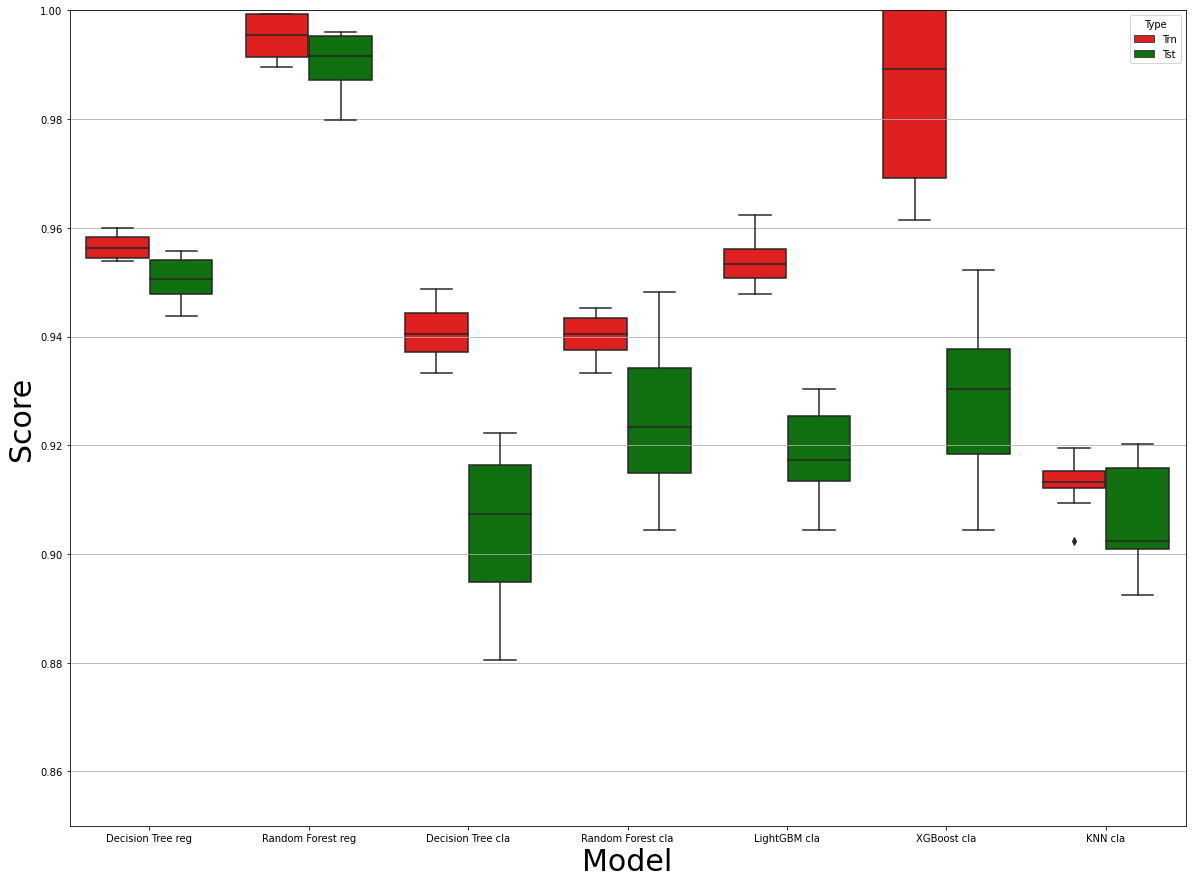

In [42]:
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data = df_compare, palette=['r','g'])
plt.ylim(.85,1)
plt.ylabel('Score',fontsize=30)
plt.xlabel('Model',fontsize = 30)
plt.grid(axis='y')

plt.savefig('modeling.png')
plt.show()

In [43]:
# Prediction
# Random Forest Regression
X = df_trn[['S' , 'K' , 'tau' , 'r']].values
y = df_trn['Value'].values
y_class = df_trn['BS'].values


clf_rf = RF_best
clf_rf.fit(X,y)
y_pred_regression = pd.DataFrame(clf_rf.predict(df_tst))


# XGBoost Classification
clf_xgb = XG_best
clf_xgb.fit(X, y_class)
y_pred_classification = pd.DataFrame(clf_xgb.predict(df_tst))

new_df = pd.concat([y_pred_regression, y_pred_classification], axis = 1,)
new_df.columns=['Value','BS']

print(new_df)

/Users/lilianawei/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


          Value  BS
0      1.384168   1
1     17.451624   0
2     10.353066   0
3     22.544001   0
4     16.494248   0
...         ...  ..
1115  11.563586   1
1116   0.396921   1
1117   0.432358   1
1118  26.039065   0
1119  15.883722   0

[1120 rows x 2 columns]


In [44]:
new_df.to_csv('Predictions.csv', index=False)

In [45]:
print('duration: ', datetime.now() - start_time)

duration:  0:50:32.262241
